# 2D Inverse Kinematics Tutorial - Mathematical Approach

### The Problem

Given a target position (x, y), we need to find the joint angles θ₁ and θ₂ that will position the robot's end-effector at that target.

**Why is this challenging?**
- We have 2 equations but need to solve for 2 angles
- The equations involve trigonometric functions  
- There might be 0, 1, or 2 solutions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 11

### Robot Arm Class

In [2]:
class RobotArm:
    """Simple 2-DOF robot arm for inverse kinematics"""
    
    def __init__(self, L1=120, L2=100):
        self.L1 = L1  # Upper arm length
        self.L2 = L2  # Forearm length
        self.max_reach = L1 + L2
        self.min_reach = abs(L1 - L2)
        
        print(f"Robot Arm Setup:")
        print(f"  Upper arm (L₁): {L1}")
        print(f"  Forearm (L₂): {L2}")
        print(f"  Reach range: {self.min_reach} to {self.max_reach}")
    
    def forward_kinematics(self, theta1, theta2):
        """Calculate end-effector position from joint angles"""
        # Elbow position
        elbow_x = self.L1 * np.cos(theta1)
        elbow_y = self.L1 * np.sin(theta1)
        
        # End-effector position
        end_x = elbow_x + self.L2 * np.cos(theta1 + theta2)
        end_y = elbow_y + self.L2 * np.sin(theta1 + theta2)
        
        return end_x, end_y, elbow_x, elbow_y
    
    def is_reachable(self, x, y):
        """Check if target position is reachable"""
        distance = np.sqrt(x**2 + y**2)
        return self.min_reach <= distance <= self.max_reach, distance
    
    def solve_ik(self, target_x, target_y, elbow_up=False):
        """Solve inverse kinematics"""
        
        # Check reachability
        reachable, distance = self.is_reachable(target_x, target_y)
        if not reachable:
            return None
        
        # Step 1: Calculate θ₂
        cos_theta2 = (target_x**2 + target_y**2 - self.L1**2 - self.L2**2) / (2 * self.L1 * self.L2)
        cos_theta2 = np.clip(cos_theta2, -1.0, 1.0)  # Handle numerical precision
        
        if elbow_up:
            theta2 = np.arccos(cos_theta2)
        else:
            theta2 = -np.arccos(cos_theta2)
        
        # Step 2: Calculate θ₁
        theta1 = np.arctan2(target_y, target_x) - np.arctan2(self.L2 * np.sin(theta2), 
                                                             self.L1 + self.L2 * np.cos(theta2))
        
        return theta1, theta2
    
    def plot_solution(self, target_x, target_y, show_both=True):
        """Visualize the IK solution"""
        fig, ax = plt.subplots(1, 1, figsize=(10, 8))
        
        # Draw workspace boundaries
        max_circle = Circle((0, 0), self.max_reach, fill=False, color='lightgray', linestyle='--')
        min_circle = Circle((0, 0), self.min_reach, fill=False, color='lightcoral', linestyle=':')
        ax.add_patch(max_circle)
        ax.add_patch(min_circle)
        
        # Check if target is reachable
        reachable, distance = self.is_reachable(target_x, target_y)
        
        if not reachable:
            ax.plot(target_x, target_y, 'rx', markersize=15, label='Unreachable')
            ax.text(target_x + 10, target_y + 10, f'Distance: {distance:.1f}\nMax: {self.max_reach}', 
                   bbox=dict(boxstyle="round", facecolor="red", alpha=0.3))
        else:
            # Plot primary solution (elbow down)
            solution = self.solve_ik(target_x, target_y, elbow_up=False)
            if solution:
                theta1, theta2 = solution
                end_x, end_y, elbow_x, elbow_y = self.forward_kinematics(theta1, theta2)
                
                # Draw arm links
                ax.plot([0, elbow_x], [0, elbow_y], 'b-', linewidth=8, alpha=0.7, label='Upper Arm')
                ax.plot([elbow_x, end_x], [elbow_y, end_y], 'r-', linewidth=6, alpha=0.7, label='Forearm')
                
                # Draw joints
                ax.plot(0, 0, 'ko', markersize=10, label='Base')
                ax.plot(elbow_x, elbow_y, 'bo', markersize=8)
                ax.plot(end_x, end_y, 'ro', markersize=8, label='End Effector')
                
                # Add angle annotations
                ax.text(20, 20, f'θ₁ = {np.degrees(theta1):.1f}°', fontsize=12, fontweight='bold')
                ax.text(elbow_x + 15, elbow_y + 15, f'θ₂ = {np.degrees(theta2):.1f}°', fontsize=12, fontweight='bold')
            
            # Show alternative solution
            if show_both:
                alt_solution = self.solve_ik(target_x, target_y, elbow_up=True)
                if alt_solution:
                    theta1_alt, theta2_alt = alt_solution
                    end_x_alt, end_y_alt, elbow_x_alt, elbow_y_alt = self.forward_kinematics(theta1_alt, theta2_alt)
                    
                    ax.plot([0, elbow_x_alt], [0, elbow_y_alt], 'g--', linewidth=4, alpha=0.6)
                    ax.plot([elbow_x_alt, end_x_alt], [elbow_y_alt, end_y_alt], 'g--', linewidth=3, alpha=0.6)
                    ax.plot(elbow_x_alt, elbow_y_alt, 'go', markersize=6, alpha=0.8, label='Alt Config')
                    ax.plot(end_x_alt, end_y_alt, 'gs', markersize=6, alpha=0.8)
            
            # Mark target
            ax.plot(target_x, target_y, 'g*', markersize=15, label='Target')
        
        # Format plot
        ax.set_xlim(-self.max_reach*1.1, self.max_reach*1.1)
        ax.set_ylim(-self.max_reach*1.1, self.max_reach*1.1)
        ax.set_aspect('equal')
        ax.grid(True, alpha=0.3)
        ax.legend()
        ax.set_title(f'IK Solution for Target ({target_x}, {target_y})', fontweight='bold')
        plt.tight_layout()
        plt.show()

# Create robot instance
robot = RobotArm(L1=120, L2=100)

Robot Arm Setup:
  Upper arm (L₁): 120
  Forearm (L₂): 100
  Reach range: 20 to 220


### The Mathematics

The key insight is using a **constraint equation**. The distance from base to target must equal the sum of link projections:

```
x² + y² = L₁² + L₂² + 2·L₁·L₂·cos(θ₂)
```

**Solving for θ₂:**
```
cos(θ₂) = (x² + y² - L₁² - L₂²) / (2·L₁·L₂)
θ₂ = ±arccos(...)  
```
The ± gives us two solutions: elbow up and elbow down.

**Solving for θ₁:**
```
θ₁ = atan2(y,x) - atan2(L₂·sin(θ₂), L₁ + L₂·cos(θ₂))
```


### Step-by-Step Example

In [3]:
def solve_step_by_step(target_x, target_y):
    """Detailed walkthrough of IK solution"""
    
    print(f"Solving for target: ({target_x}, {target_y})")
    print("-" * 40)
    
    # Step 1: Check reachability
    distance = np.sqrt(target_x**2 + target_y**2)
    print(f"Step 1: Check reachability")
    print(f"  Distance to target: {distance:.1f}")
    print(f"  Robot reach range: {robot.min_reach} to {robot.max_reach}")
    
    reachable, _ = robot.is_reachable(target_x, target_y)
    if not reachable:
        print(f"  Result: UNREACHABLE")
        return
    
    print(f"  Result: Reachable")
    
    # Step 2: Calculate θ₂
    print(f"\nStep 2: Calculate θ₂")
    numerator = target_x**2 + target_y**2 - robot.L1**2 - robot.L2**2
    denominator = 2 * robot.L1 * robot.L2
    cos_theta2 = numerator / denominator
    
    print(f"  cos(θ₂) = ({target_x}² + {target_y}² - {robot.L1}² - {robot.L2}²) / (2·{robot.L1}·{robot.L2})")
    print(f"  cos(θ₂) = {cos_theta2:.4f}")
    
    theta2_down = -np.arccos(cos_theta2)
    theta2_up = np.arccos(cos_theta2)
    
    print(f"  θ₂ = {np.degrees(theta2_down):.1f}° (elbow down) or {np.degrees(theta2_up):.1f}° (elbow up)")
    
    # Step 3: Calculate θ₁ (using elbow down)
    print(f"\nStep 3: Calculate θ₁ (elbow down configuration)")
    
    part1 = np.arctan2(target_y, target_x)
    part2 = np.arctan2(robot.L2 * np.sin(theta2_down), robot.L1 + robot.L2 * np.cos(theta2_down))
    theta1 = part1 - part2
    
    print(f"  θ₁ = atan2({target_y}, {target_x}) - atan2(...)")
    print(f"  θ₁ = {np.degrees(part1):.1f}° - {np.degrees(part2):.1f}° = {np.degrees(theta1):.1f}°")
    
    # Step 4: Verify
    print(f"\nStep 4: Verify solution")
    end_x, end_y, _, _ = robot.forward_kinematics(theta1, theta2_down)
    error = np.sqrt((end_x - target_x)**2 + (end_y - target_y)**2)
    
    print(f"  Forward kinematics result: ({end_x:.2f}, {end_y:.2f})")
    print(f"  Target: ({target_x}, {target_y})")
    print(f"  Error: {error:.6f}")
    
    return theta1, theta2_down

# Run example
result = solve_step_by_step(150, 80)

Solving for target: (150, 80)
----------------------------------------
Step 1: Check reachability
  Distance to target: 170.0
  Robot reach range: 20 to 220
  Result: Reachable

Step 2: Calculate θ₂
  cos(θ₂) = (150² + 80² - 120² - 100²) / (2·120·100)
  cos(θ₂) = 0.1875
  θ₂ = -79.2° (elbow down) or 79.2° (elbow up)

Step 3: Calculate θ₁ (elbow down configuration)
  θ₁ = atan2(80, 150) - atan2(...)
  θ₁ = 28.1° - -35.3° = 63.4°

Step 4: Verify solution
  Forward kinematics result: (150.00, 80.00)
  Target: (150, 80)
  Error: 0.000000


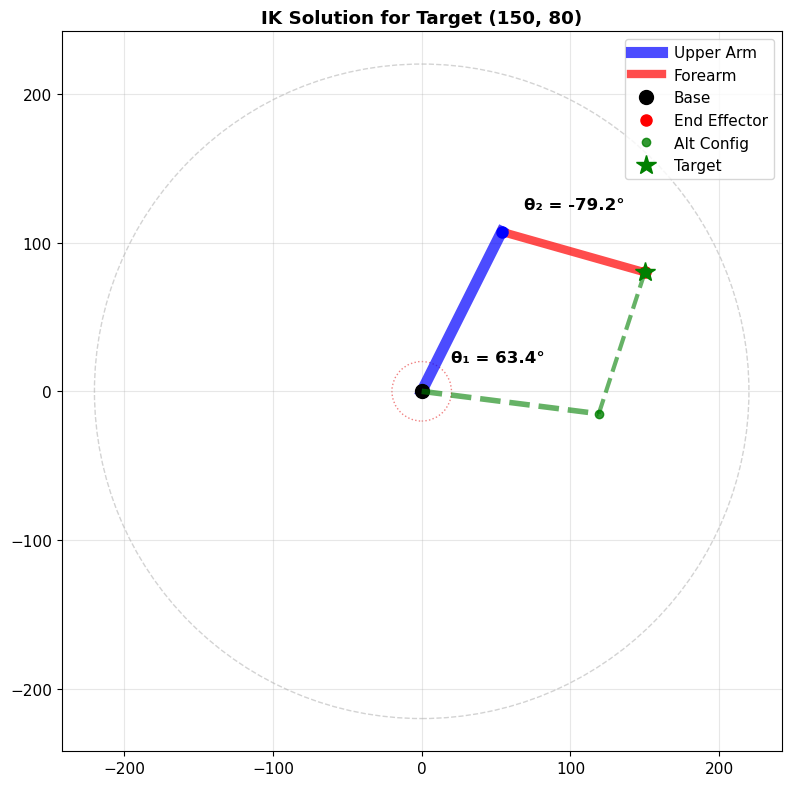

In [4]:
# Visualize the solution
if result:
    robot.plot_solution(150, 80, show_both=True)

### Key Demonstrations

Demo 1: Multiple Solutions
Same target can be reached with two different arm configurations


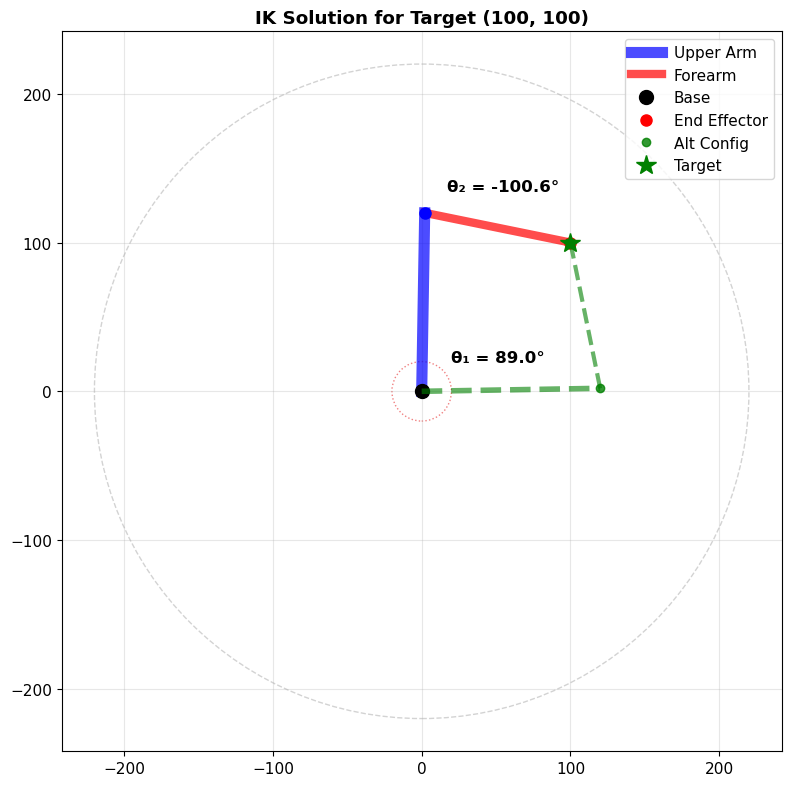

In [5]:
# Demo 1: Multiple solutions for same target
print("Demo 1: Multiple Solutions")
print("Same target can be reached with two different arm configurations")
robot.plot_solution(100, 100, show_both=True)

Demo 2: Edge Cases


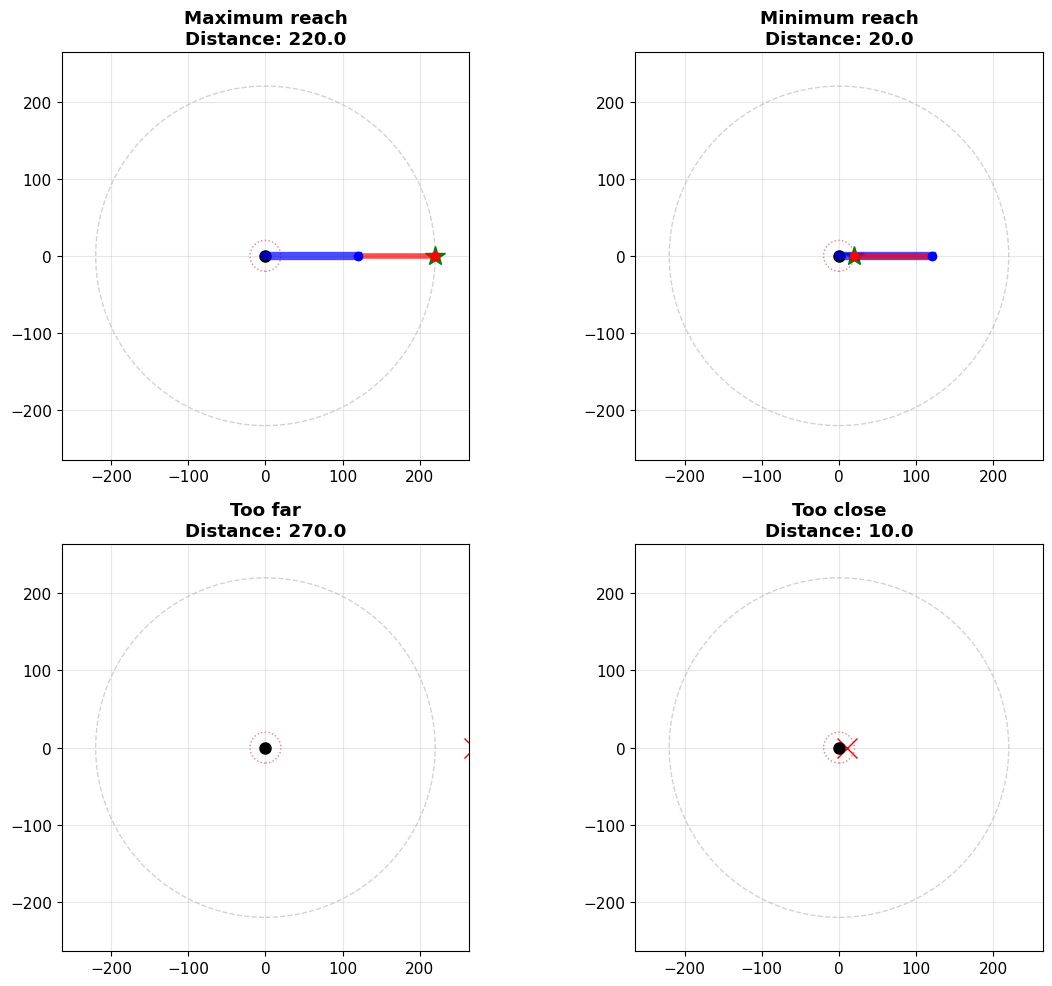

In [6]:
# Demo 2: Edge cases
print("Demo 2: Edge Cases")

test_cases = [
    (robot.max_reach, 0, "Maximum reach"),
    (robot.min_reach, 0, "Minimum reach"), 
    (robot.max_reach + 50, 0, "Too far"),
    (10, 0, "Too close")
]

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for i, (tx, ty, description) in enumerate(test_cases):
    ax = axes[i]
    
    # Draw workspace
    max_circle = Circle((0, 0), robot.max_reach, fill=False, color='lightgray', linestyle='--')
    min_circle = Circle((0, 0), robot.min_reach, fill=False, color='lightcoral', linestyle=':')
    ax.add_patch(max_circle)
    ax.add_patch(min_circle)
    
    # Check reachability and plot
    reachable, distance = robot.is_reachable(tx, ty)
    color = 'green' if reachable else 'red'
    marker = '*' if reachable else 'x'
    
    ax.plot(tx, ty, color=color, marker=marker, markersize=15)
    ax.plot(0, 0, 'ko', markersize=8)
    
    # If reachable, show arm configuration
    if reachable:
        solution = robot.solve_ik(tx, ty, elbow_up=False)
        if solution:
            theta1, theta2 = solution
            end_x, end_y, elbow_x, elbow_y = robot.forward_kinematics(theta1, theta2)
            ax.plot([0, elbow_x], [0, elbow_y], 'b-', linewidth=6, alpha=0.7)
            ax.plot([elbow_x, end_x], [elbow_y, end_y], 'r-', linewidth=4, alpha=0.7)
            ax.plot(elbow_x, elbow_y, 'bo', markersize=6)
            ax.plot(end_x, end_y, 'ro', markersize=6)
    
    ax.set_xlim(-robot.max_reach*1.2, robot.max_reach*1.2)
    ax.set_ylim(-robot.max_reach*1.2, robot.max_reach*1.2)
    ax.set_aspect('equal')
    ax.set_title(f"{description}\nDistance: {distance:.1f}", fontweight='bold')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Practice Problems

Try solving these problems by hand, then check your answers:

In [8]:
problems = [
    (130, 90, "Easy symmetric case"),
    (200, 50, "Near maximum reach"),
    (-100, 80, "Negative x coordinate"),
    (0, 150, "Straight up")
]

print("Practice Problems:")
print("=" * 20)

for i, (x, y, description) in enumerate(problems, 1):
    print(f"\nProblem {i}: Target ({x}, {y}) - {description}")
    
    reachable, distance = robot.is_reachable(x, y)
    if reachable:
        solution = robot.solve_ik(x, y, elbow_up=False)
        if solution:
            theta1, theta2 = solution
            print(f"  Answer: θ₁ = {np.degrees(theta1):.1f}°, θ₂ = {np.degrees(theta2):.1f}°")
    else:
        print(f"  Answer: Unreachable (distance {distance:.1f} > max reach {robot.max_reach})")

Practice Problems:

Problem 1: Target (130, 90) - Easy symmetric case
  Answer: θ₁ = 73.9°, θ₂ = -88.6°

Problem 2: Target (200, 50) - Near maximum reach
  Answer: θ₁ = 32.6°, θ₂ = -41.0°

Problem 3: Target (-100, 80) - Negative x coordinate
  Answer: θ₁ = 188.7°, θ₂ = -109.5°

Problem 4: Target (0, 150) - Straight up
  Answer: θ₁ = 131.6°, θ₂ = -94.5°


### Summary

**What you learned:**

1. **The Problem**: Convert target (x,y) to joint angles (θ₁, θ₂)

2. **Key Insight**: Use constraint equation x² + y² = L₁² + L₂² + 2·L₁·L₂·cos(θ₂)

3. **Solution Process**:
   - Check if target is reachable
   - Solve for θ₂ using constraint equation
   - Solve for θ₁ using geometry
   - Verify with forward kinematics

4. **Important Points**:
   - Two solutions exist (elbow up/down)
   - Always check reachability first
   - Verify your answer
   - Watch for singularities at boundaries

**Applications:**
- Industrial robot programming
- Video game animation
- Robotic surgery
- 3D printing systems

**Next Steps:**
- Try different arm lengths
- Explore 3D kinematics (6-DOF)
- Learn about motion planning